# Propensity Score matching on FF Profiles

In [43]:
from Matcher import *
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

read in pre-aggregated data. Collected via [this](https://github.com/mozilla/addon-adhoc-analysis/blob/engagement-study/engagement-study/DataCollection.ipynb) script.

In [44]:
test = pd.DataFrame.from_csv('test_pre.csv', index_col=None)
control = pd.DataFrame.from_csv('control_pre.csv', index_col=None)

In [45]:
test.head()

,architecture,avg_active_ticks,avg_pings_per_day,build_version,client_id,cores,final_default,final_telemetry,has_system,inital_telemetry,initial_default,memory_mb,most_consecutive_days,os,total_active_days,treatment,unique_locales,weekend_days
0,x86,153.399994,2.500000,44.0,344cb05b-27cf-4ba0-8513-380f34fe576f,4.0,True,False,True,False,True,16317,0,Windows_NT,2,True,1,1
1,x86-64,191.012817,3.900000,43.0.4,47d457a8-a0bb-4db1-8bd6-f0d09260f0f1,2.0,True,False,True,False,True,3976,25,Windows_NT,40,True,1,13
2,x86,231.156250,2.909091,44.0.2,ab3df6bc-fbea-43ae-99df-6f81cd16ecbb,3.0,True,False,False,False,True,8138,5,Windows_NT,11,True,1,0
3,x86,193.576584,1.585714,44.0,b8ccd163-91f5-4d14-af4b-8b3bcdbd940f,2.0,True,False,True,False,False,6052,45,Windows_NT,70,True,1,19
4,x86-64,1609.875000,1.230769,44.0.2,e15080b4-5c52-a247-a12b-aa6c100783bc,4.0,True,False,False,False,True,16384,6,Darwin,13,True,1,2


`Matcher` allows for forward stepwise regression to optimize the formula for the logistic regression model, we define it below to save time. In general, this model building process should be iterative and the formula known prior to matching the data. The stepwise process is intended to be a tool in this process.

`transform`=True creates 3 (log, sqrt, pow2) different transformations for all continuous variables

In [46]:
form = 'treatment ~' + '+'.join(['memory_mb',
                                'os',
                                'has_system',
                                'build_version',
                                'weekend_days',
                                'log_weekend_days',
                                'total_active_days',
                                'log_total_active_days',
                                'avg_pings_per_day',
                                'log_avg_pings_per_day',
                                'avg_active_ticks',
                                'log_avg_active_ticks'])

m = Matcher(test, control, exclude=['client_id', 'unique_locales'], formula=form, transform=True)

n majority: 155375
n minority: 9026


fit 100 balanced models (ntest=ncontrol) to calculate propensity score

In [47]:
m.fit_scores(balance=True, nmodels=100)

Fitting 100 Models on Balanced Samples...100.0%
Average Accuracy: 65.34%


In [48]:
m.predict_scores()

Caclculating Propensity Scores...100.0%

find one control profile for every test profile with a score within 0.001

In [49]:
m.match(nmatches=1, threshold=0.0001, tie_strategy='random')

Matching Control to Test...100.0%

distribution of scores for all data (before matching)

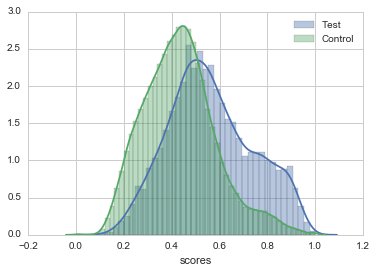

In [50]:
m.plot_scores()

we want the ECDFs on the right (after matching) to look the same

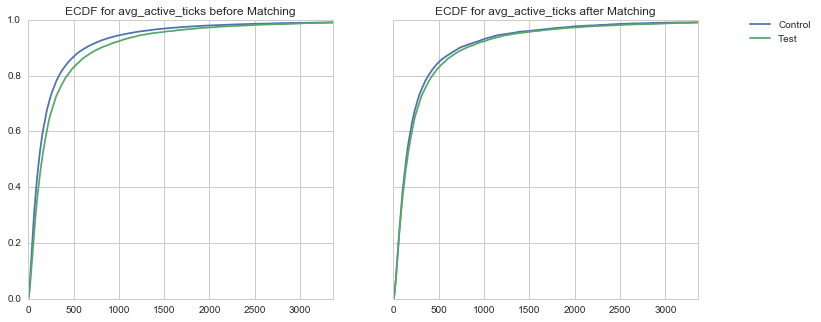

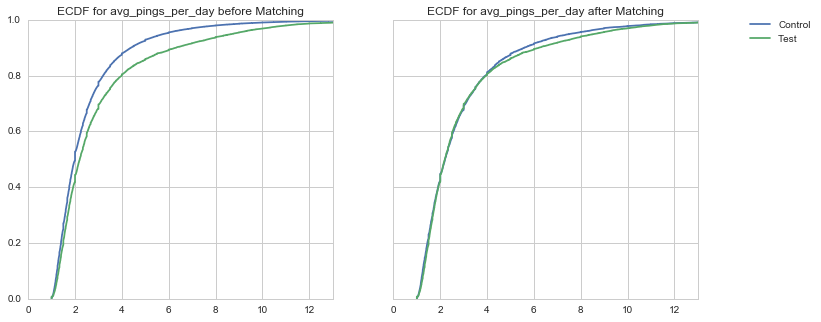

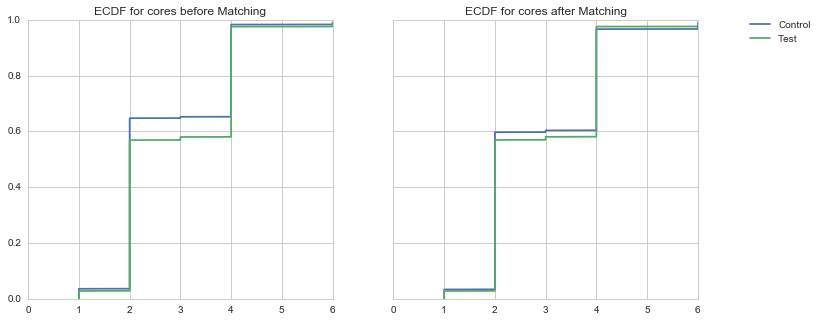

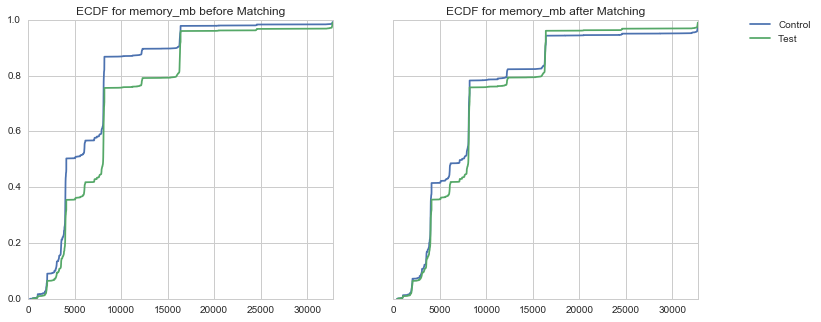

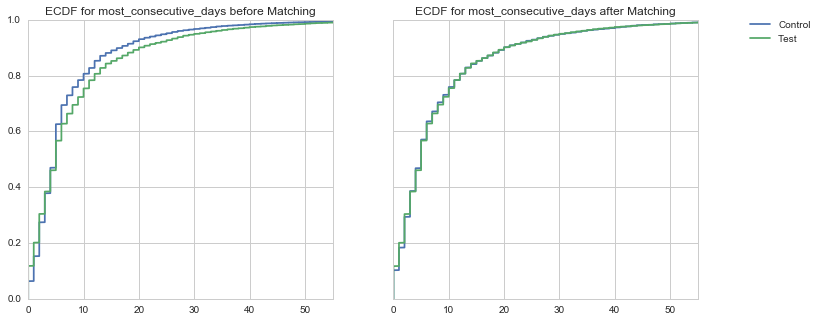

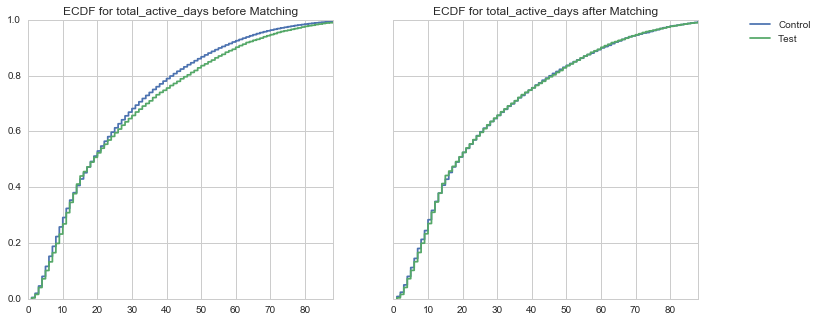

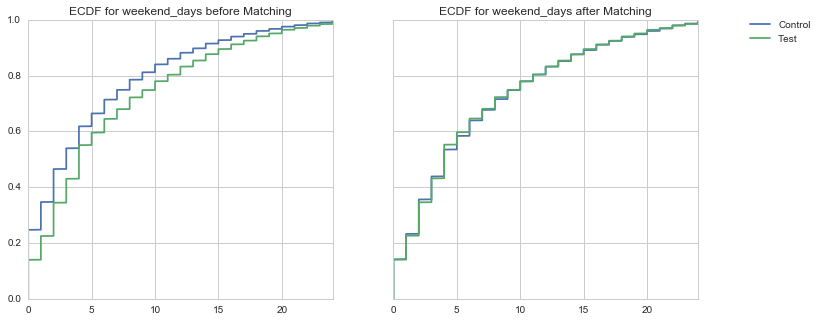

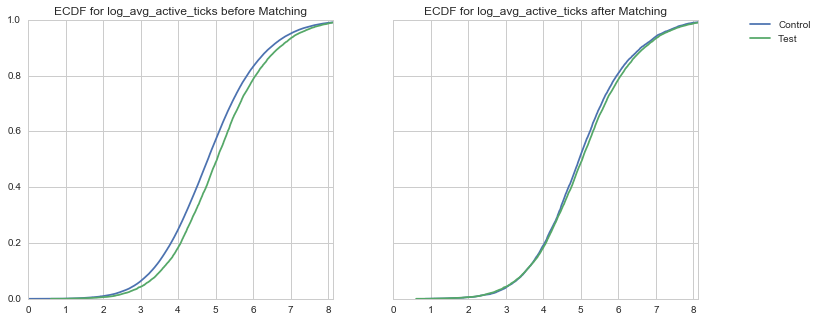

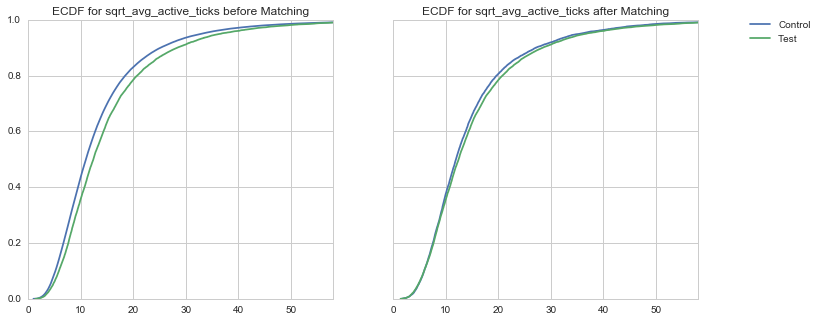

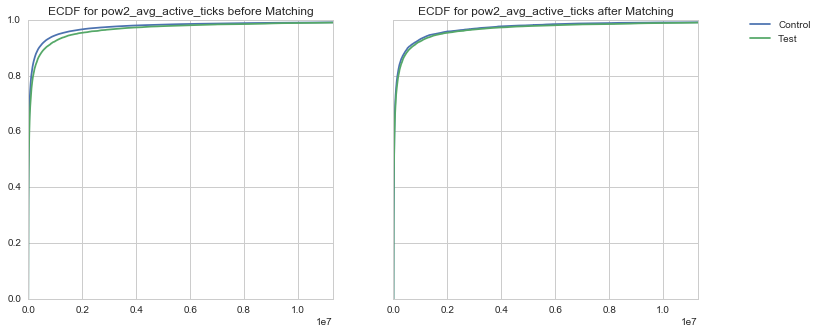

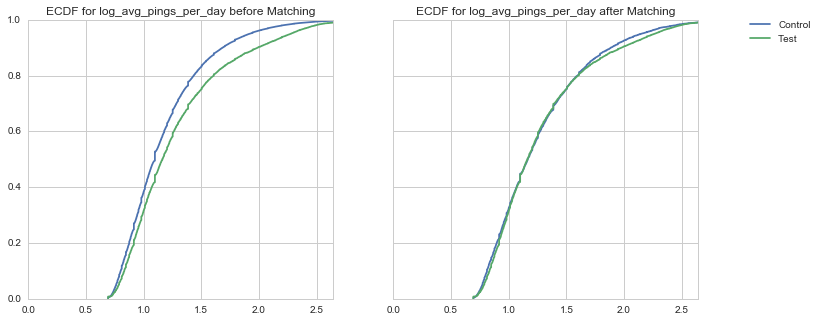

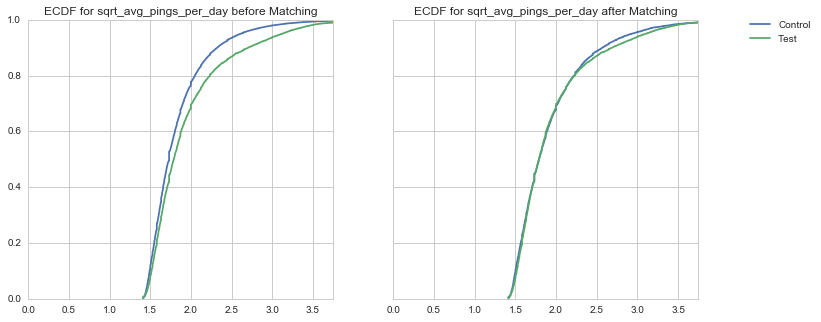

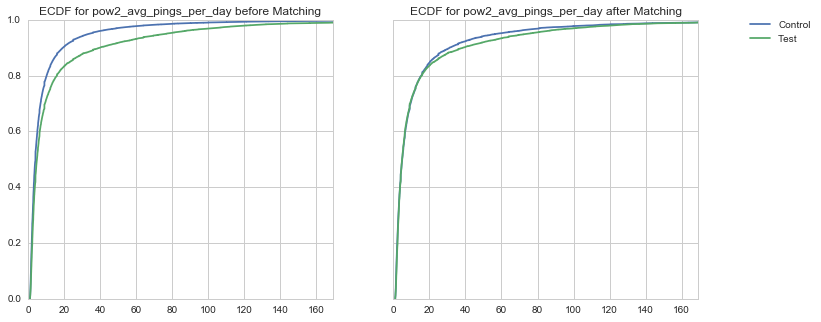

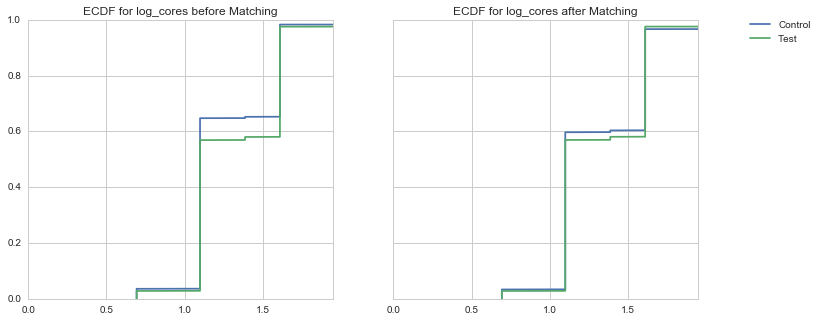

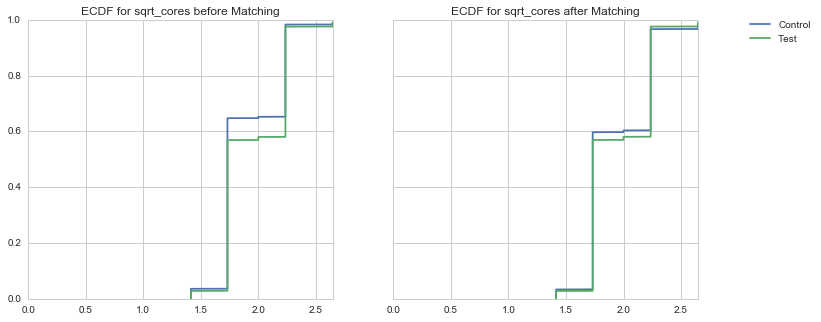

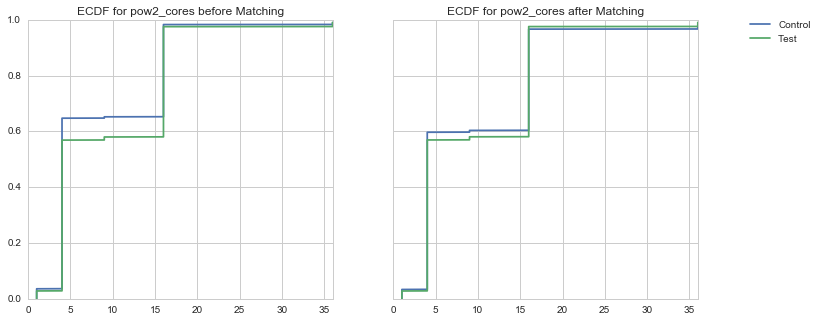

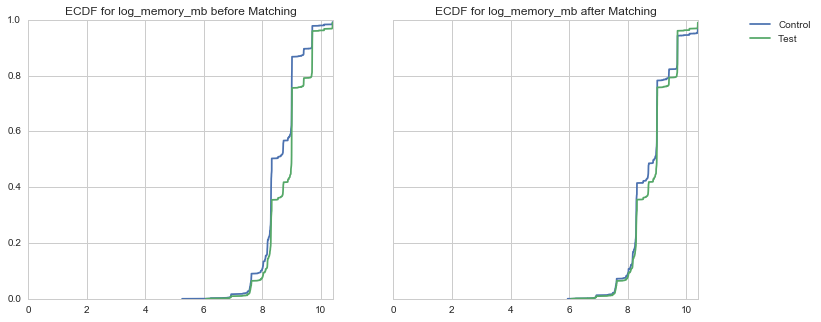

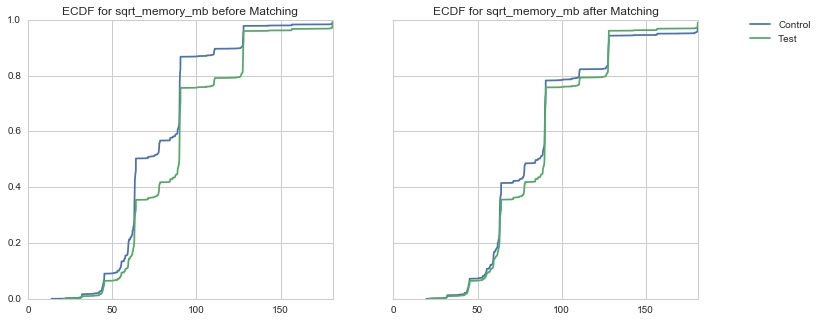

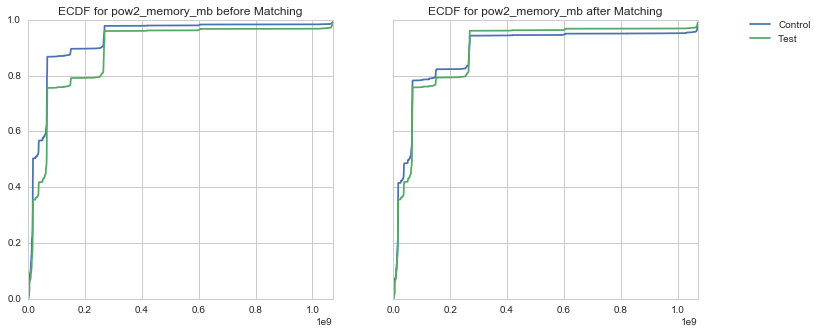

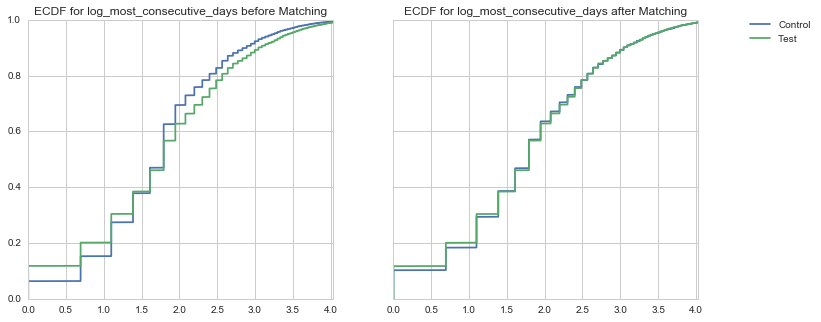

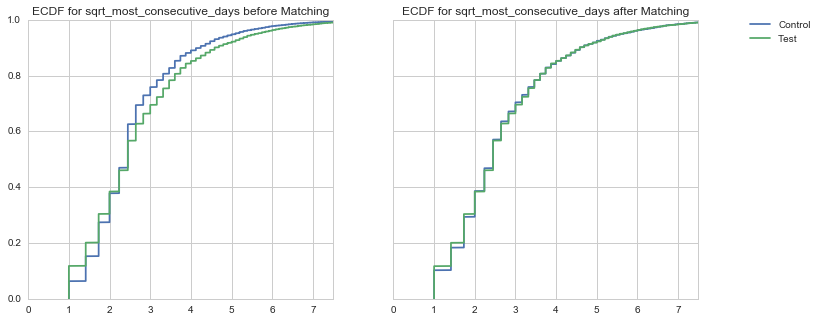

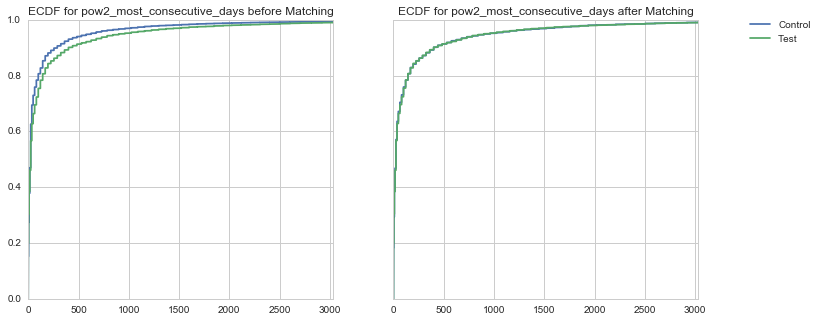

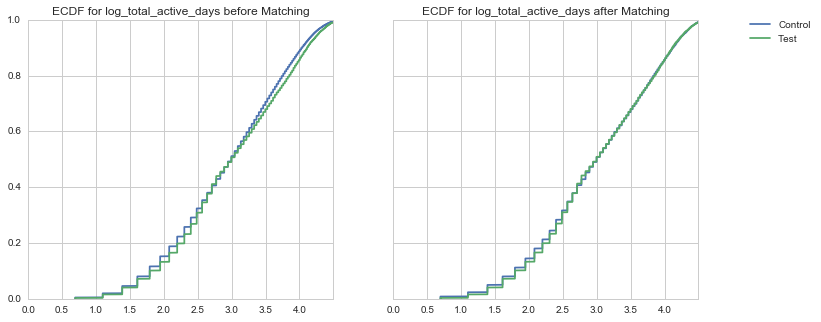

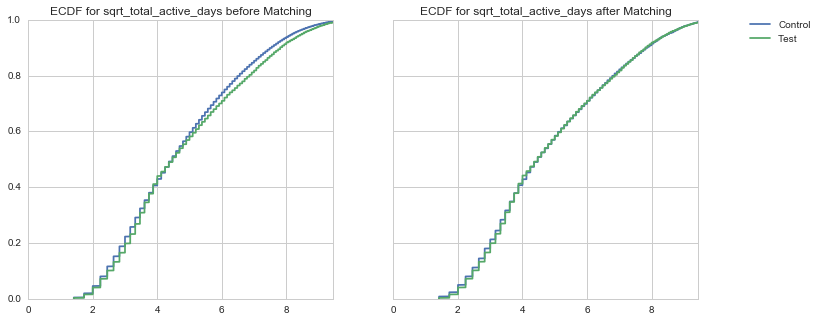

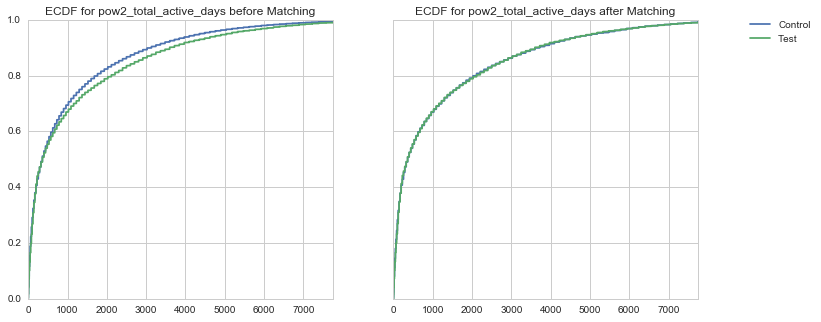

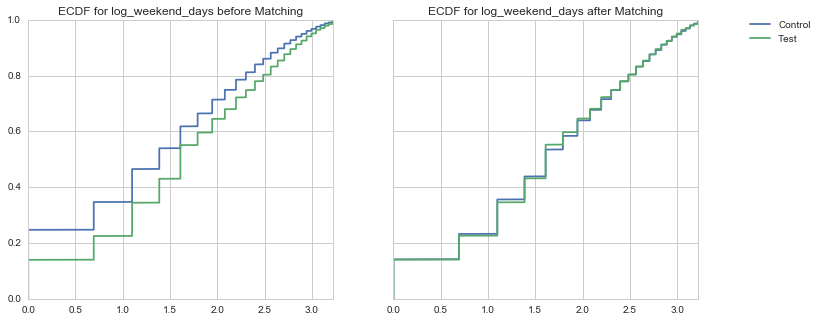

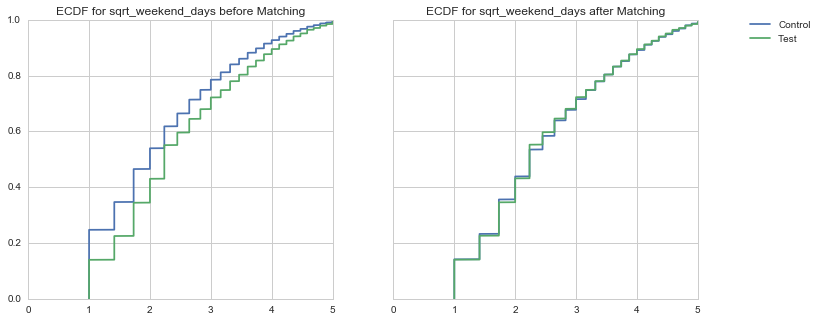

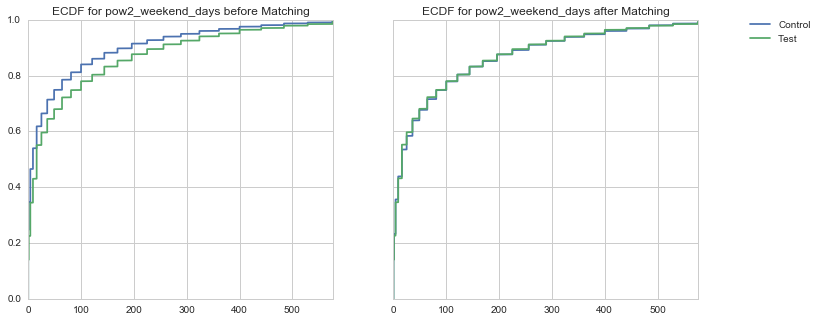

In [51]:
m.plot_ecdfs()

we can test equivilence of these distributions using a KS-test (we want p > 0.05)

In [52]:
m.ks_by_column()

,var,p_before,p_after
0,avg_active_ticks,0.0,0.000
1,avg_pings_per_day,0.0,0.002
2,cores,0.0,0.000
3,memory_mb,0.0,0.000
4,most_consecutive_days,0.0,0.066
5,total_active_days,0.0,0.196
6,weekend_days,0.0,0.076
7,log_avg_active_ticks,0.0,0.000
8,sqrt_avg_active_ticks,0.0,0.002
9,pow2_avg_active_ticks,0.0,0.000


the bar plots are (proportionTest - proportionControl) for all discrete variables

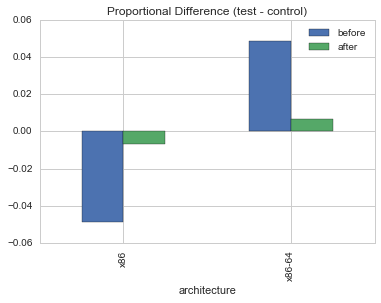

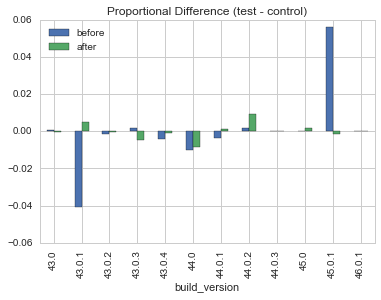

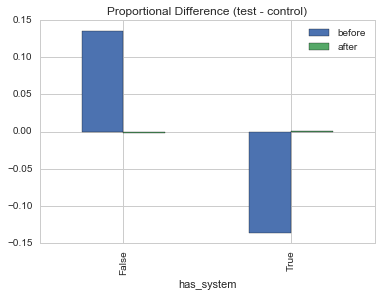

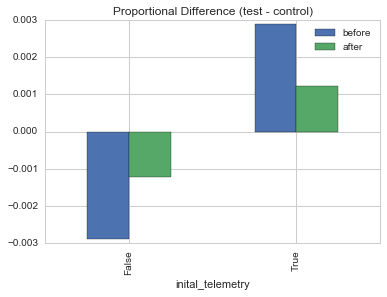

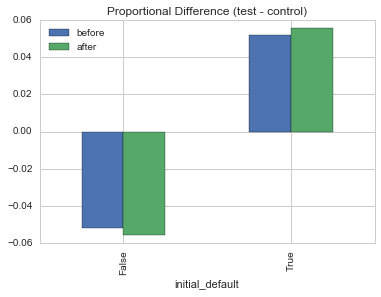

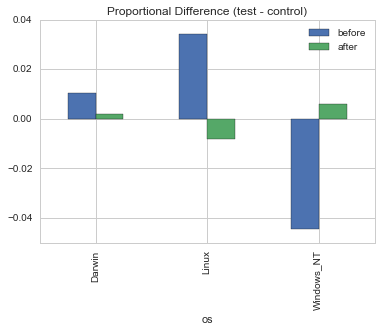

In [53]:
m.plot_bars()

we can test whether these proportions of statistically different using Chi-Squared test

In [54]:
m.prop_test_by_column()

,var,before,after
0,architecture,0.061457,0.062844
1,build_version,1.000000,1.000000
2,has_system,0.055256,0.065269
3,inital_telemetry,0.000000,0.000000
4,initial_default,0.164777,0.165829
5,os,0.989897,0.999659


In [55]:
len(m.matched_data[m.matched_data.treatment==True]), len(m.test)

(8972, 9026)